# Digits classifier

Let's build a model that is able to recognize a single digit from 0 to 9 from an image.

In [1]:
# loading and setting up dependencies
import fastbook

fastbook.setup_book()

from fastai.vision.all import *
from fastbook import *
from matplotlib import pyplot as plt
from torch.nn import functional as F

## Importing the dataset

In [2]:
# import MNIST dataset
path_to_mnist = untar_data(URLs.MNIST)
Path.BASE_PATH = path_to_mnist

path_to_mnist.ls()

(#2) [Path('testing'),Path('training')]

As you can see from the previous output, this dataset is organized into separate folders for testing and training sets.

In [3]:
# let's see what's in the training set
(path_to_mnist / 'training').ls(), (path_to_mnist / 'training/1').ls()

((#10) [Path('training/6'),Path('training/4'),Path('training/9'),Path('training/7'),Path('training/3'),Path('training/5'),Path('training/8'),Path('training/2'),Path('training/1'),Path('training/0')],
 (#6742) [Path('training/1/3488.png'),Path('training/1/41249.png'),Path('training/1/53593.png'),Path('training/1/48085.png'),Path('training/1/51436.png'),Path('training/1/48189.png'),Path('training/1/32921.png'),Path('training/1/59932.png'),Path('training/1/1915.png'),Path('training/1/1060.png')...])

In [4]:
# now let's see what's in the testing set
(path_to_mnist / 'testing').ls(), (path_to_mnist / 'testing/1').ls()

((#10) [Path('testing/6'),Path('testing/4'),Path('testing/9'),Path('testing/7'),Path('testing/3'),Path('testing/5'),Path('testing/8'),Path('testing/2'),Path('testing/1'),Path('testing/0')],
 (#1135) [Path('testing/1/2315.png'),Path('testing/1/1350.png'),Path('testing/1/1214.png'),Path('testing/1/8078.png'),Path('testing/1/2136.png'),Path('testing/1/6101.png'),Path('testing/1/8261.png'),Path('testing/1/4104.png'),Path('testing/1/5859.png'),Path('testing/1/8088.png')...])

Let's save the paths to all training digits in a list, and all testing digits in another list.

In [314]:
mnist_training_0s = (path_to_mnist / 'training' / '0').ls().sorted()
mnist_training_1s = (path_to_mnist / 'training' / '1').ls().sorted()
mnist_training_2s = (path_to_mnist / 'training' / '2').ls().sorted()
mnist_training_3s = (path_to_mnist / 'training' / '3').ls().sorted()
mnist_training_4s = (path_to_mnist / 'training' / '4').ls().sorted()
mnist_training_5s = (path_to_mnist / 'training' / '5').ls().sorted()
mnist_training_6s = (path_to_mnist / 'training' / '6').ls().sorted()
mnist_training_7s = (path_to_mnist / 'training' / '7').ls().sorted()
mnist_training_8s = (path_to_mnist / 'training' / '8').ls().sorted()
mnist_training_9s = (path_to_mnist / 'training' / '9').ls().sorted()

mnist_testing_0s = (path_to_mnist / 'testing' / '0').ls().sorted()
mnist_testing_1s = (path_to_mnist / 'testing' / '1').ls().sorted()
mnist_testing_2s = (path_to_mnist / 'testing' / '2').ls().sorted()
mnist_testing_3s = (path_to_mnist / 'testing' / '3').ls().sorted()
mnist_testing_4s = (path_to_mnist / 'testing' / '4').ls().sorted()
mnist_testing_5s = (path_to_mnist / 'testing' / '5').ls().sorted()
mnist_testing_6s = (path_to_mnist / 'testing' / '6').ls().sorted()
mnist_testing_7s = (path_to_mnist / 'testing' / '7').ls().sorted()
mnist_testing_8s = (path_to_mnist / 'testing' / '8').ls().sorted()
mnist_testing_9s = (path_to_mnist / 'testing' / '9').ls().sorted()

## defining our baseline model

The _baseline_ of our classifier will be very simple, as it should be: it will work by finding the average pixel value for every pixel of each nuber.

This gives us group averages that we may call "ideal digits". We classify a digit as x by finding the ideal digit whose average is closest to the image we are trying to classify.

## creating "ideal digits" with rank-3 tensors

For every pixel position, we want to compute the average over all the images of the intensity of that pixel. 

To do this we first combine all the images in this list into a single three-dimensional tensor. 

The most common way to describe such a tensor is to call it a _rank-3 tensor_.

See an example of what that might look like below:

![rank-3 tensor.png](./rank-3-tensor.png)

### how did we conclude that we needed a rank-3 tensor?

- Each image is a 2d matrix of pixels (rows and columns, e.g. a _rank-2 tensor_)
- Each element in an image matrix corresponds to a pixel intensity (a scalar value, e.g. a _rank-1 tensor_)
- To ease computing of the average of each pixel intensity over all images, you would stack each of these matrices on top of each other: there you have it, a _rank-3 tensor_

In [315]:
# create lists of tensors containing all digits (one for every digit)
list_0s = [tensor(Image.open(digit)) for digit in mnist_training_0s]
list_1s = [tensor(Image.open(digit)) for digit in mnist_training_1s]
list_2s = [tensor(Image.open(digit)) for digit in mnist_training_2s]
list_3s = [tensor(Image.open(digit)) for digit in mnist_training_3s]
list_4s = [tensor(Image.open(digit)) for digit in mnist_training_4s]
list_5s = [tensor(Image.open(digit)) for digit in mnist_training_5s]
list_6s = [tensor(Image.open(digit)) for digit in mnist_training_6s]
list_7s = [tensor(Image.open(digit)) for digit in mnist_training_7s]
list_8s = [tensor(Image.open(digit)) for digit in mnist_training_8s]
list_9s = [tensor(Image.open(digit)) for digit in mnist_training_9s]

list_0s_test = [tensor(Image.open(digit)) for digit in mnist_testing_0s]
list_1s_test = [tensor(Image.open(digit)) for digit in mnist_testing_1s]
list_2s_test = [tensor(Image.open(digit)) for digit in mnist_testing_2s]
list_3s_test = [tensor(Image.open(digit)) for digit in mnist_testing_3s]
list_4s_test = [tensor(Image.open(digit)) for digit in mnist_testing_4s]
list_5s_test = [tensor(Image.open(digit)) for digit in mnist_testing_5s]
list_6s_test = [tensor(Image.open(digit)) for digit in mnist_testing_6s]
list_7s_test = [tensor(Image.open(digit)) for digit in mnist_testing_7s]
list_8s_test = [tensor(Image.open(digit)) for digit in mnist_testing_8s]
list_9s_test = [tensor(Image.open(digit)) for digit in mnist_testing_9s]

In [316]:
# each digits tensor has more or less 6000 images of 28x28 pixels in it for our training data
# and 1000 images give or less for our testing data
len(list_3s),len(list_3s_test)

(6131, 1010)

<Axes: >

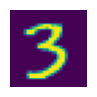

In [317]:
# Jupyter ships with a function called `show_image` that knows how to render a tensor as an image
show_image(list_3s[1])

In [318]:
# let's stack our images and cast our stacked tensors as float tensors for further computation,
# we also normalise our pixel values to be between 0 and 1 by dividing by 255, this will improve our model's accuracy
stacked_0s = torch.stack(list_0s).float()/255
stacked_1s = torch.stack(list_1s).float()/255
stacked_2s = torch.stack(list_2s).float()/255
stacked_3s = torch.stack(list_3s).float()/255
stacked_4s = torch.stack(list_4s).float()/255
stacked_5s = torch.stack(list_5s).float()/255
stacked_6s = torch.stack(list_6s).float()/255
stacked_7s = torch.stack(list_7s).float()/255
stacked_8s = torch.stack(list_8s).float()/255
stacked_9s = torch.stack(list_9s).float()/255
# a _shape_ tells us the length of each axis of a tensor
stacked_3s.shape # the output says "we have 6131 images, each of size 28x28 pixels".

torch.Size([6131, 28, 28])

In [319]:
# the _length_ of a tensor's shape is its _rank_ (2 notations for the same thing)
len(stacked_3s.shape), stacked_3s.ndim

(3, 3)

The _dimension_ 0 of our rank-3 tensor is the number of images.

Here is how you would compute the average pixel intensity for each pixel position:

(<Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >,
 <Axes: >)

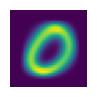

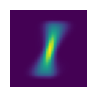

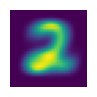

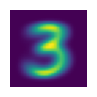

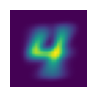

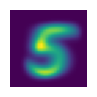

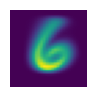

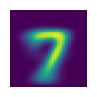

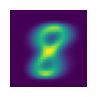

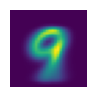

In [320]:
ideal_0 = stacked_0s.mean(0)
ideal_1 = stacked_1s.mean(0)
ideal_2 = stacked_2s.mean(0)
ideal_3 = stacked_3s.mean(0)
ideal_4 = stacked_4s.mean(0)
ideal_5 = stacked_5s.mean(0)
ideal_6 = stacked_6s.mean(0)
ideal_7 = stacked_7s.mean(0)
ideal_8 = stacked_8s.mean(0)
ideal_9 = stacked_9s.mean(0)
show_image(ideal_0), show_image(ideal_1), show_image(ideal_2), show_image(ideal_3), show_image(ideal_4), show_image(ideal_5), show_image(ideal_6), show_image(ideal_7), show_image(ideal_8), show_image(ideal_9)

## Test the baseline model

Now that we have an idea of what our ideal digits look like, we can try to classify our images. To test our baseline, we would pick an arbitrary number from the dataset and measure its distance from its _ideal_ representation.

<Axes: >

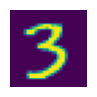

In [321]:
# here is our sample number for our test
ex3_2 = stacked_3s[1]
show_image(ex3_2)

To calculate the distance from the baseline `3`, we can't just add up the differences in intensity between each of the pixels of both images. It is so because some differences would cancel out (light vs dark pixels), and that would be misleading as very different pixels could add up to zero, which would mean "no difference from the ideal digit representation".

There are two main ways data scientists measure distance in this context:

- take the mean absolute value of differences: this is called _mean absolute difference_ or _L1 norm_
- take the mean of the square of differences (which makes everything positive) and then take the square root (which undoes the squaring): this is called _root mean squared error_ or _L2 norm_

In [322]:
# let's try the `L1` norm
ex3_2_dist_l1 = (ex3_2 - ideal_3).abs().mean()

ex3_2_dist_l1

tensor(0.1114)

In [323]:
# let's try the `L2` norm now
ex3_2_dist_l2 = ((ex3_2 - ideal_3)**2).mean().sqrt()

ex3_2_dist_l2

tensor(0.2021)

In [324]:
# let's predict what an example number is using the examples of 3 and 7 we have,
# the closer we are to 0 for a given ideal digit, the more likely it is that our example is that digit

# `L1` norm
dist7_l1 = (ex3_2 - ideal_7).abs().mean()
dist3_l1 = (ex3_2 - ideal_3).abs().mean()
dist7_l1, dist3_l1

(tensor(0.1586), tensor(0.1114))

In [325]:
# we'll use the `L2` norm
dist7_l2 = ((ex3_2 - ideal_7)**2).mean().sqrt()
dist3_l2 = ((ex3_2 - ideal_3)**2).mean().sqrt()
dist7_l2, dist3_l2

(tensor(0.3021), tensor(0.2021))

From the little experiment we've just run, we can see that our baseline model predicts right in this particular case, as both results are greater for a 7 than they would have been for a 3.

We could have done the same thing with `PyTorch`, which provides loss functions (among many other things), as shown below:

In [326]:
dist7_l1_torch = F.l1_loss(ex3_2.float(), ideal_7)
dist7_l1_torch

tensor(0.1586)

In [327]:
dist7_l2_torch = F.mse_loss(ex3_2, ideal_7).sqrt()
dist7_l2_torch

tensor(0.3021)

We could use PyTorch tensors and MSE loss to train our model, since MSE will penalise more the bigger the difference between the prediction and the target is; this is what we want since we have a wide range of values to predict (0 to 9). Something to be aware of...

But let's first try mean absolute error (MAE) loss for now.

## Defining a metric for our baseline model

A metric is a number that is calculated based on the predictions of our model, and the correct labels in our dataset, in order to tell us how good our model is.

In practice, _accuracy_ is a common metric for classification models.

- The _error rate_ in deep learning refers to the difference between the predicted output and the actual output of a neural network. It is a measure of how well the network is performing on a given task. In this context, _accuracy_ can be defined as `1.0 - error rate`.

A metric is always calculated over a _validation_ set.

To get a validation set, we need to set aside some of the data of the training set entirely, so it's not seen by the model at all during training.

In [328]:
# let's create test tensors for our digits

# let's do that by picking the last 1000 images of each digit,
# we also want to divide tensors by 255 to normalize the pixel values between 0 and 1
mnist_test_0s = torch.stack(list_0s_test).float()/255
mnist_test_1s = torch.stack(list_1s_test).float()/255
mnist_test_2s = torch.stack(list_2s_test).float()/255
mnist_test_3s = torch.stack(list_3s_test).float()/255
mnist_test_4s = torch.stack(list_4s_test).float()/255
mnist_test_5s = torch.stack(list_5s_test).float()/255
mnist_test_6s = torch.stack(list_6s_test).float()/255
mnist_test_7s = torch.stack(list_7s_test).float()/255
mnist_test_8s = torch.stack(list_8s_test).float()/255
mnist_test_9s = torch.stack(list_9s_test).float()/255


In [329]:
# now let's write the function that will give use the mean absolute difference losses for a given image
def mnist_mad_distance(a,b): return (a-b).abs().mean((-1,-2))
mnist_mad_distance(ex3_2, ideal_3)


tensor(0.1114)

### why `mean((-1,-2))`

The `mean` function in `PyTorch` can take a tuple of axes to take the mean of. 
In this case, we want to take the mean over the last two dimensions (in this case, the horizontal and vertical dimensions of an image).

The tuple `(-1,-2)` represents a range of axes.

This effectively allows us to make batch calculations on rank-3 tensors, as you will see in the example below.

In [330]:
# applying the same calculation for every image in our validation set
# for every image, we averaged the intensity of all pixels in that image;
# we are left with a rank-1 tensor of a thousand numbers
valid_3_l1_distances = mnist_mad_distance(mnist_test_3s, ideal_3)
valid_3_l1_distances, valid_3_l1_distances.shape

(tensor([0.1280, 0.1623, 0.1242,  ..., 0.1508, 0.1263, 0.1260]),
 torch.Size([1010]))

`PyTorch` is so versatile it didn't even complain about shapes not matching and calculated the distance for each image instead !

This is made possible because `PyTorch` uses _broadcasting_ under the hood: e.g. the ability expand a lower rank tensor to have the same size as a higher rank input tensor during a calculation. This is why this type of operation is possible:

```python
tensor([1,2,3]) + tensor(1) # tensor([2,3,4])
```

Now let's continue with the function that determines which number is predicted by our baseline model:

In [331]:
def is_y(x): 
    mads = tensor([mnist_mad_distance(x,ideal_0), mnist_mad_distance(x,ideal_1), mnist_mad_distance(x,ideal_2), mnist_mad_distance(x,ideal_3), 
        mnist_mad_distance(x,ideal_4), mnist_mad_distance(x,ideal_5), mnist_mad_distance(x,ideal_6), mnist_mad_distance(x,ideal_7), 
        mnist_mad_distance(x,ideal_8), mnist_mad_distance(x,ideal_9)])
    # get the index of the minimum value
    return mads.argmin().float()

# let's test the function
is_y(ex3_2)

tensor(3.)

In [332]:
# let's do the same thing at scale
mnist_test_3s.shape

torch.Size([1010, 28, 28])

In [333]:
# since we have a rank-3 tensors of 1000 images, we'll need to call our function without its first axis
def is_y_batch(x_batch):
    # create an empty tensor
    results = tensor([])
    for i in range(x_batch.shape[0]):
        x = x_batch[i]
        y = is_y(x).item()
        # push the float value into the tensor
        results = torch.cat((results, tensor([y])))
    return results

In [334]:
# let's check our accuracy for all digits
for i in range(0, 10):
    predicted_y = is_y_batch(globals()[f'mnist_test_{i}s'])
    number_of_y =  predicted_y.lt(i+1) & predicted_y.ge(i)
    print(f'accuracy for {i}s: {(number_of_y.sum() / len(predicted_y))}')


accuracy for 0s: 0.8153061270713806
accuracy for 1s: 0.9982379078865051
accuracy for 2s: 0.4234496057033539
accuracy for 3s: 0.6089109182357788
accuracy for 4s: 0.6680244207382202
accuracy for 5s: 0.3262331783771515
accuracy for 6s: 0.7870563864707947
accuracy for 7s: 0.7645914554595947
accuracy for 8s: 0.4425051212310791
accuracy for 9s: 0.7760158777236938


We can conclude from the above that we have a pretty good baseline for most numbers!

However, we are underperforming for 8s, 5s, and 2s. Can we get a better result with the L2 norm?

In [335]:
def mnist_mse_distance(a,b): return F.mse_loss(a, b).sqrt()
mnist_mse_distance(ex3_2, ideal_3)

tensor(0.2021)

In [336]:
def is_y_mse(x): 
    mses = tensor([mnist_mse_distance(x,ideal_0), mnist_mse_distance(x,ideal_1), mnist_mse_distance(x,ideal_2), mnist_mse_distance(x,ideal_3), 
        mnist_mse_distance(x,ideal_4), mnist_mse_distance(x,ideal_5), mnist_mse_distance(x,ideal_6), mnist_mse_distance(x,ideal_7), 
        mnist_mse_distance(x,ideal_8), mnist_mse_distance(x,ideal_9)])
    # get the index of the minimum value
    return mses.argmin().float()

def is_y_mse_batch(x_batch):
    # create an empty tensor
    results = tensor([])
    for i in range(x_batch.shape[0]):
        x = x_batch[i]
        y = is_y_mse(x).item()
        # push the float value into the tensor
        results = torch.cat((results, tensor([y])))
    return results

# let's check our accuracy for all digits using MSE
accuracies = []
for i in range(0, 10):
    predicted_y = is_y_mse_batch(globals()[f'mnist_test_{i}s'])
    number_of_y =  predicted_y.lt(i+1) & predicted_y.ge(i)
    print(f'accuracy for {i}s: {(number_of_y.sum() / len(predicted_y))}')
    accuracies.append((number_of_y.sum() / len(predicted_y)) * 100)

print("\n")
print(f'global accuracy: {sum(accuracies) / len(accuracies)}%')

accuracy for 0s: 0.8959183692932129
accuracy for 1s: 0.9621145129203796
accuracy for 2s: 0.7567829489707947
accuracy for 3s: 0.805940568447113
accuracy for 4s: 0.8258655667304993
accuracy for 5s: 0.6860986351966858
accuracy for 6s: 0.8632568120956421
accuracy for 7s: 0.8326848149299622
accuracy for 8s: 0.7371663451194763
accuracy for 9s: 0.806739330291748


global accuracy: 81.72567749023438%


As we can see, this is way better with MSE! Now we have a very decent baseline model. No accuracy for any digit is under 50% and our global accuracy is 82%.